<a href="https://colab.research.google.com/github/flaghunter21/DSCI-619-Deep-Learning/blob/main/DSCI_619_Project_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 619 Project 8

## Cameron Lauf

In this project, we will use Deep Convolutional Generative Adversarial Network (DCGAN) to generate images of handwritten digits.

During this process, two models are trained simultaneously by an adversarial process. A *generator* learns to create images that look real, and a *discriminator* learns to tell real images apart from fake images.

When the models are trained, the generator becomes better at creating images that look real, and the discriminator becomes better at telling them apart. An equlibrium is reached when the discriminator can no longer tell real images apart from fake images.

In [21]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-m3cfjigw
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-m3cfjigw


In [22]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load and prepare MNIST dataset

We will create a generator to generate handwritten digits.

In [23]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [24]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize images

In [25]:
buffer_size = 60000
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

## Create the Generator

In [26]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Use tanh instead of LeakyReLU activation for output layer
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  return model

We can now use the generator to create an image. Note the generator is currently untrained.

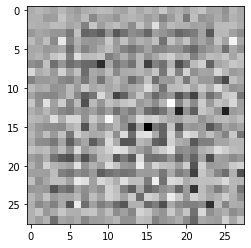

In [27]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

## Create the Discriminator

In [28]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  # Output layer
  model.add(layers.Dense(1))

  return model

We can now use the discriminator to classify our generated images as real or fake. Positive values will be for real images and negative values for fake images. The discriminator is also currently untrained.

In [29]:
discriminator = make_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00569]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [30]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss

This compares the predictions on real images to an array of 1s and the predictions on fake images to an array of 0s.

In [31]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### Generator loss

This compares the discriminators decisions on generated images to an array of 1s.

In [32]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

The training loop starts with the generator receiving a random seed as input which is useed to produce an image. The discriminator then classifies this image. The loss is calculated for each model, and the gradients are used to update both the generator and discriminator.

In [35]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Function to generate and save images

In [37]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [38]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    # Save the model every 15 seconds
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print(f'Time for epoch {epoch + 1} is {time.time()-start} seconds.')
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Train the model

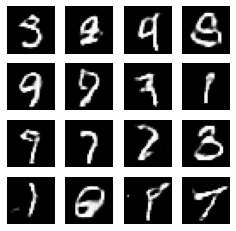

In [39]:
train(train_dataset, epochs)

## Create a GIF

We can create a GIF to show the evolution of the generated images. At first, they look like random noise, but slowly start to look more like digits.

In [40]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

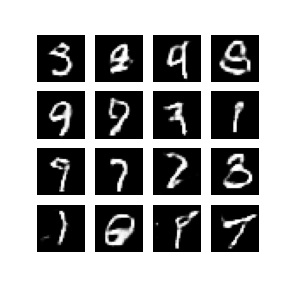

In [41]:
display_image(epochs)

In [42]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


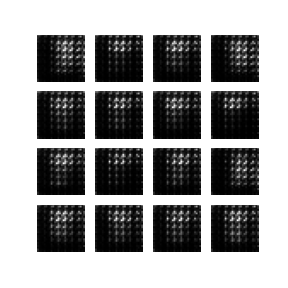

In [43]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)